# Overview
With the kernel I am trying to run a simple test on using Siamese networks for similarity on a slightly more complicated problem than standard MNIST.  The idea is to take a randomly initialized network and apply it to images to find out how similar they are. The models should make it much easier to perform tasks like Visual Search on a database of images since it will have a simple similarity metric between 0 and 1 instead of 2D arrays.

 * [Source Blog Post](http://sujitpal.blogspot.ch/2017/04/predicting-image-similarity-using.html) with this [notebook](https://github.com/sujitpal/holiday-similarity/blob/master/src/02-holidays-siamese-network.ipynb)

In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

# Load and Organize Data
Here we load and organize the data so we can easily use it inside of Keras models

In [5]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./input/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)

In [23]:
y_full

,label
0,2
1,9
2,6
3,0
4,3
...,...
59995,9
59996,1
59997,8
59998,8


In [6]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [10]:
y_train

array([[9],
       [0],
       [4],
       ...,
       [9],
       [0],
       [7]])

In [7]:
# reorganize by groups 把图像分成几个组
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4219, 4186, 4189, 4184, 4188, 4175, 4258, 4228, 4136, 4237]
test groups: [1781, 1814, 1811, 1816, 1812, 1825, 1742, 1772, 1864, 1763]


### Batch Generation
Here the idea is to make usuable batches for training the network. We need to create parallel inputs for the $A$ and $B$ images where the output is the distance. Here we make the naive assumption that if images are in the same group the similarity is 1 otherwise it is 0.

If we randomly selected all of the images we would likely end up with most images in different groups.

In [8]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

## Validate Data
Here we make sure the generator is doing something sensible, we show the images and their similarity percentage.

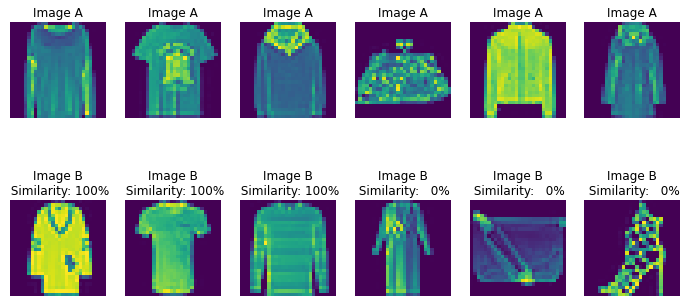

In [12]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [15]:
m_axs

array([[<AxesSubplot:title={'center':'Image A'}>,
        <AxesSubplot:title={'center':'Image A'}>,
        <AxesSubplot:title={'center':'Image A'}>,
        <AxesSubplot:title={'center':'Image A'}>,
        <AxesSubplot:title={'center':'Image A'}>,
        <AxesSubplot:title={'center':'Image A'}>],
       [<AxesSubplot:title={'center':'Image B\n Similarity: 100%'}>,
        <AxesSubplot:title={'center':'Image B\n Similarity: 100%'}>,
        <AxesSubplot:title={'center':'Image B\n Similarity: 100%'}>,
        <AxesSubplot:title={'center':'Image B\n Similarity:   0%'}>,
        <AxesSubplot:title={'center':'Image B\n Similarity:   0%'}>,
        <AxesSubplot:title={'center':'Image B\n Similarity:   0%'}>]],
      dtype=object)

In [16]:
x_train.shape[1:]

(28, 28, 1)

# Feature Generation
Here we make the feature generation network to process images into features. The network starts off randomly initialized and will be trained to generate useful vector features from input images (_hopefully_)

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = (16,16,3), name = 'FeatureNet_ImageInput')
n_layer = img_in

n_layer = Conv2D(64, kernel_size = (3,3), activation = 'linear',padding = "same")(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
n_layer = Conv2D(128, kernel_size = (3,3), activation = 'linear', padding = "same")(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
n_layer = MaxPool2D((2,2))(n_layer)
"""
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
"""
n_layer = Conv2D(256, kernel_size = (3,3), activation = 'linear', padding = "same")(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 16, 16, 3)]      0         
 tLayer)                                                         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 batch_normalization_29 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_30 (Bat  (None, 16, 16,

# Siamese Model
We apply the feature generating model to both images and then combine them together to predict if they are similar or not. The model is designed to very simple. The ultimate idea is when a new image is taken that a feature vector can be calculated for it using the _FeatureGenerationModel_. All existing images have been pre-calculated and stored in a database of feature vectors. The model can be applied using a few vector additions and multiplications to determine the most similar images. These operations can be implemented as a stored procedure or similar task inside the database itself since they do not require an entire deep learning framework to run.

In [12]:
from keras.layers import concatenate
img_a_in = Input(shape = (16,16,3), name = 'ImageA_Input')
img_b_in = Input(shape = (16,16,3), name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in) #是为上一层的网络结构
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense((2), activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('softmax')(combined_features)
"""
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
"""
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 8, 8, 256)   372608      ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 8, 8, 512)    0           ['FeatureGeneratio

In [20]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

## Visual Model Feedback
Here we visualize what the model does by taking a small sample of randomly selected A and B images the first half from the same category and the second from different categories. We then show the actual distance (0 for the same category and 1 for different categories) as well as the model predicted distance. The first run here is with a completely untrained network so we do not expect meaningful results.

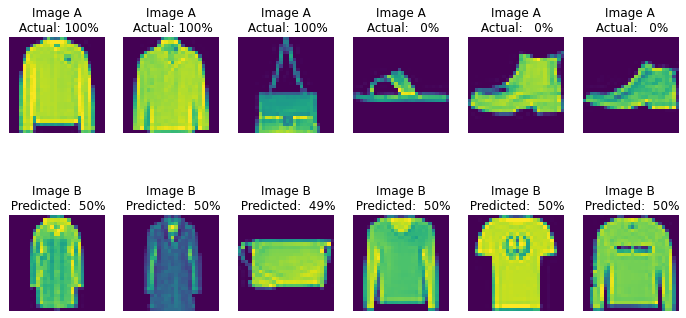

In [21]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [22]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10


<ipython-input-22-ade925f9341a>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(siam_gen(train_groups),


500/500 [==============================] - 24s 45ms/step - loss: 0.6814 - mae: 0.4827 - val_loss: 0.6011 - val_mae: 0.4365
Epoch 2/10
500/500 [==============================] - 28s 55ms/step - loss: 0.5435 - mae: 0.3920 - val_loss: 0.4346 - val_mae: 0.3138
Epoch 3/10
500/500 [==============================] - 25s 50ms/step - loss: 0.4668 - mae: 0.3209 - val_loss: 0.3821 - val_mae: 0.2627
Epoch 4/10
500/500 [==============================] - 24s 49ms/step - loss: 0.4347 - mae: 0.2925 - val_loss: 0.3618 - val_mae: 0.2460
Epoch 5/10
500/500 [==============================] - 22s 44ms/step - loss: 0.4179 - mae: 0.2778 - val_loss: 0.3484 - val_mae: 0.2312
Epoch 6/10
500/500 [==============================] - 21s 43ms/step - loss: 0.4049 - mae: 0.2659 - val_loss: 0.3373 - val_mae: 0.2111
Epoch 7/10
500/500 [==============================] - 21s 42ms/step - loss: 0.3967 - mae: 0.2591 - val_loss: 0.3323 - val_mae: 0.2090
Epoch 8/10
500/500 [==============================] - 23s 46ms/step - los

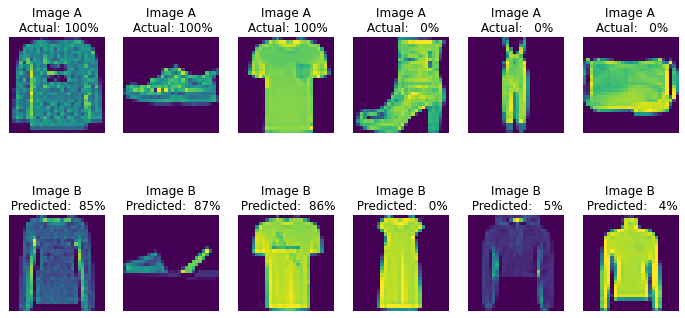

In [24]:
_ = show_model_output()

# T-Shirt vs Ankle Boot-Plot
Here we take an random t-shirt and ankle boot (categories 0 and 9) images and calculate the distance using our network to the other images

In [25]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

141/141 [==============================] - 3s 22ms/step


In [28]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('./tshirt-boot-dist.png')
plt.show(block=False)

TypeError: must be real number, not str

TypeError: must be real number, not str

<Figure size 720x720 with 1 Axes>

## Examining the Features
Here we aim to answer the more general question: did we generate useful features with the Feature Generation model? And how can we visualize this.

In [29]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

141/141 [==============================] - 2s 15ms/step


## Neighbor Visualization
For this we use the TSNE neighborhood embedding to visualize the features on a 2D plane and see if it roughly corresponds to the groups. We use the test data for this example as well since the training has been contaminated

In [31]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.001s...
[t-SNE] Computed neighbors for 18000 samples in 6.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

In [39]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

TypeError: must be real number, not str

TypeError: must be real number, not str

<Figure size 720x720 with 1 Axes>

In [34]:
feature_model.save('fashion_feature_model.h5')

In [35]:
similarity_model.save('fashion_similarity_model.h5')